In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from scipy.interpolate import LSQUnivariateSpline

import warnings
warnings.filterwarnings('ignore')

In [111]:
#Q1a

In [112]:
wine = pd.read_csv('/Users/liujingyang/Desktop/strongdrink.txt')

In [113]:
X=wine[["alco","malic","tot_phen","color_int"]]
y=wine["cultivar"]

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)
logit = LogisticRegression(random_state = 20, solver = 'lbfgs', 
                           multi_class = 'multinomial').fit(X_train, y_train)

In [115]:
j1 = [logit.intercept_[0]] + logit.coef_[0].tolist()
j2 = [logit.intercept_[1]] + logit.coef_[1].tolist()

In [116]:
results = pd.DataFrame(data = {'j = 1':j1, 'j = 2':j2}, 
                       index = ['intercept', 'b1', 'b2', 'b3', 'b4'])
results

,j = 1,j = 2
intercept,-24.027617,22.780733
b1,1.701734,-1.466297
b2,-0.265788,-0.332951
b3,1.224101,0.663556
b4,0.022507,-0.922682


In [117]:
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



In [118]:
error_rate = (np.array([1,1,1])-np.array([0.87,1,1])).tolist()
pd.DataFrame(data = {'error rate':error_rate}, 
                       index = ['j1', 'j2', 'j3'])

,error rate
j1,0.13
j2,0.00
j3,0.00


In [119]:
wine['cultivar'].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

J2 has the most observations, while J3 is best at predicting.

In [120]:
MSE_vs = ((y_test - y_pred) ** 2).sum() / y_pred.shape[0]
print('Validation set MSE = ', MSE_vs)

Validation set MSE =  0.045454545454545456


In [121]:
#Q1b

In [122]:
Xvars = X.values
yvars = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
yt = np.zeros(N_loo)
yp = np.zeros(N_loo)

In [123]:
for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(random_state = 20, solver = 'lbfgs', 
                                multi_class = 'multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    yt[test_index] = y_test
    yp[test_index] = y_pred
    
    if y_test == y_pred:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()

print('Test estimate MSE LOOCV =', MSE_loo,
      '\nTest estimate MSE standard error =', MSE_loo_std)

Test estimate MSE LOOCV = 0.07954545454545454 
Test estimate MSE standard error = 0.2705882022679695


In [124]:
print(classification_report(yt, yp))

             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



In [125]:
error_rate_loo = (np.array([1,1,1])-np.array([0.90,0.91,0.96])).tolist()
pd.DataFrame(data = {'error rate':error_rate, 'error rate loo':error_rate_loo}, 
                       index = ['j1', 'j2', 'j3'])

,error rate,error rate loo
j1,0.13,0.10
j2,0.00,0.09
j3,0.00,0.04


The error rate for J1 decreases from 0.13 to 0.1, while that for J2 and J3  increases to 0.09 and 0.04 from zero respectively.

In [126]:
#Q1c

In [127]:
k = 4
kf = KFold(n_splits = k, random_state = 10, shuffle = True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)
yt = np.zeros(N_loo)
yp = np.zeros(N_loo)
k_ind = int(0)

for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(random_state = 20, solver = 'lbfgs', 
                                multi_class = 'multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    yt[test_index] = y_test
    yp[test_index] = y_pred
    
    mse = []
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            mse.append(0)
        else:
            mse.append(1)
    MSE_vec_kf[k_ind] = np.array(mse).mean()
    k_ind += 1

In [128]:
MSE_vec_kf = np.array(MSE_vec_kf)
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('Test estimate MSE k-fold =', MSE_kf)
print('Test estimate MSE standard error =', MSE_kf_std)

Test estimate MSE k-fold = 0.09090909090909091
Test estimate MSE standard error = 0.04821182598999188


In [129]:
print(classification_report(yt, yp))

             precision    recall  f1-score   support

        1.0       0.87      0.93      0.90        59
        2.0       0.91      0.87      0.89        71
        3.0       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176



In [130]:
error_rate_kf = (np.array([1,1,1])-np.array([0.87,0.91,0.96])).tolist()
pd.DataFrame(data = {'error rate':error_rate, 'error rate loo':error_rate_loo,'error rate kf':error_rate_kf}, index = ['j1', 'j2', 'j3'])

,error rate,error rate loo,error rate kf
j1,0.13,0.10,0.13
j2,0.00,0.09,0.09
j3,0.00,0.04,0.04


J1 error rate in k-fold is the same with that in part(a). J2 and J3 error rates in k-fold are the same with those in part(b).

In [131]:
#Q2a

In [132]:
Index=pd.read_csv("/Users/liujingyang/Desktop/CoolIndex.txt",names=["Age","Cool"])

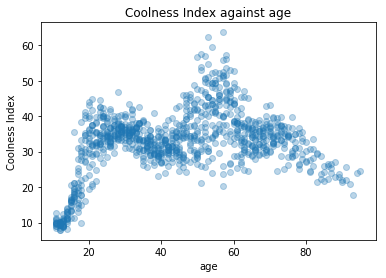

In [133]:
plt.scatter(Index.Age,Index.Cool,alpha=0.3)
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [134]:
#Q2b

In [135]:
Index["G1"]=np.where((Index.Age>=11) & (Index.Age<22),1,0)
Index["G2"]=np.where((Index.Age>=22) & (Index.Age<40),1,0)
Index["G3"]=np.where((Index.Age>=40) & (Index.Age<59),1,0)
Index["G4"]=np.where((Index.Age>=59) & (Index.Age<77),1,0)
Index["G5"]=np.where((Index.Age>=77) & (Index.Age<=95),1,0)

In [136]:
X=Index[["G1","G2","G3","G4","G5"]]
res=sm.OLS(Index.Cool,X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Cool   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 27 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        01:43:03   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G1            20.1025      0.562     35.746      0.0

In [137]:
res.predict([0,0,0,1,0])

array([35.22540004])

The predicted coolness of a 73-year old is 35.22540004.

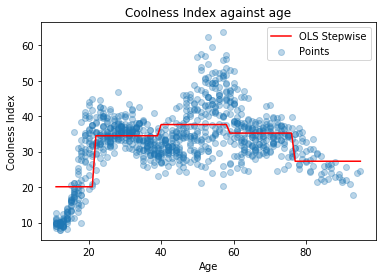

In [138]:
plt.scatter(Index.Age,Index.Cool,alpha=0.3,label="Points")
plt.plot(Index.Age,res.predict(),"r",label = "OLS Stepwise")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [139]:
#Q2c

In [140]:
df=Index.groupby('Age').mean()
df['Age']=df.index

In [141]:
knots=[22,40,59,77]
ls=LSQUnivariateSpline(np.array(df.Age), np.array(df.Cool), t=knots, k=1)

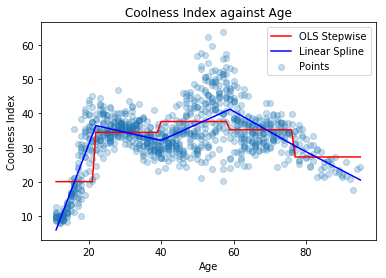

In [142]:
plt.scatter(Index.Age, Index.Cool, alpha=0.25,label="Points")
plt.plot(Index.Age, res.predict(),"r",label = "OLS Stepwise")
plt.plot(df.Age,ls(df.Age),"b",label = "Linear Spline")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against Age")
plt.show()

In [143]:
ls(73)

array(32.86784862)

The predicted coolness of a 73-year old from the cubic spline is 32.86784862.

In [144]:
#Q2d

In [145]:
cs=LSQUnivariateSpline(np.array(df.Age), np.array(df.Cool), t=knots, k=3)

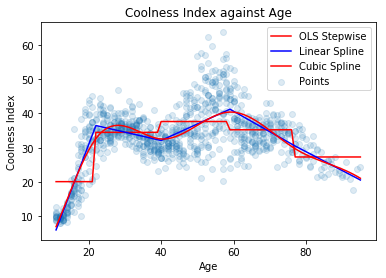

In [146]:
plt.scatter(Index.Age, Index.Cool, alpha=0.15,label="Points")
plt.plot(Index.Age,res.predict(),"r",label = "OLS Stepwise")
plt.plot(df.Age,ls(df.Age),"b",label = "Linear Spline")
plt.plot(df.Age,cs(df.Age),"r",label = "Cubic Spline")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against Age")
plt.show()

In [147]:
cs(73)

array(32.64230107)

The predicted coolness of a 73-year old from the cubic spline is 32.64230107.